In [1]:
using FourierFlows
using CairoMakie
using Printf
using JLD2
using StatsBase
include("AnalysisUtils.jl")
include("../../rsw/RSWUtils.jl")

compute_rsw_fields (generic function with 1 method)

In [17]:
run_directory = "/scratch/nad9961/rsw_ray/66609698/1/"
Nsnapshots = count_snapshots(run_directory)
Nrsw_snapshots = count_key_snapshots(run_directory, "rsw")
rsw_params = read_rsw_params(run_directory)
nx, Lx = get_grid_size(run_directory, "rsw")
grid = TwoDGrid(; nx, Lx)

t0, x0, k0, u0 = load_snapshot(run_directory, 2)
tf, xf, kf, uf = load_snapshot(run_directory, 5000)
t_rsw, sol1 = load_key_snapshot(run_directory, "rsw", Nrsw_snapshots)
Npackets = size(x0, 1)
u1h = sol1[:,:,1]
v1h = sol1[:,:,2]
η1h = sol1[:,:,3]

f0, Cg, freq_sign = read_parameters(run_directory)
ω0 = compute_ω(k0, f0, Cg, freq_sign)
ω1 = compute_ω(kf, f0, Cg, freq_sign)
Ω0 = compute_Ω(k0, u0, f0, Cg, freq_sign)
Ω1 = compute_Ω(kf, uf, f0, Cg, freq_sign)

((ugh, vgh, ηgh), (uwh, vwh, ηwh)) = wave_balanced_decomposition(u1h, v1h, η1h, grid, rsw_params)
println(maximum(abs.(ω1)))
Nbins = 100
ω_max = grid.nkr * 2/3
ω_min = f0
bins = (0:(Nbins-1))/(Nbins-1) * (ω_max - ω_min) .+ ω_min
dx = bins[2] - bins[1]
bin_centers = bins[2:end] .- dx/2
histcounts = fit(Histogram, abs.(ω1), bins, closed=:left)
histcounts = StatsBase.normalize(histcounts, mode=:density)
energy_estimate = bin_centers .* histcounts.weights / Npackets

1130.0369404582061


99-element Vector{Float64}:
 0.16322051699798884
 0.2376939225905012
 0.2722483417775371
 0.32516654741646034
 0.3433466845219678
 0.3817511530205755
 0.3707459704710705
 0.374328855004641
 0.40283088306389236
 0.3774494435527537
 0.37352989876624376
 0.38131786384204824
 0.37088719736231435
 ⋮
 0.059930903368657175
 0.06611158918626237
 0.03342200553063119
 0.056313694113551985
 0.03415442740563118
 0.06328783696240718
 0.05233027392094678
 0.011751020072710396
 0.05936545192605198
 0.07197096418626238
 0.030293077525525992
 0.04283755462948638

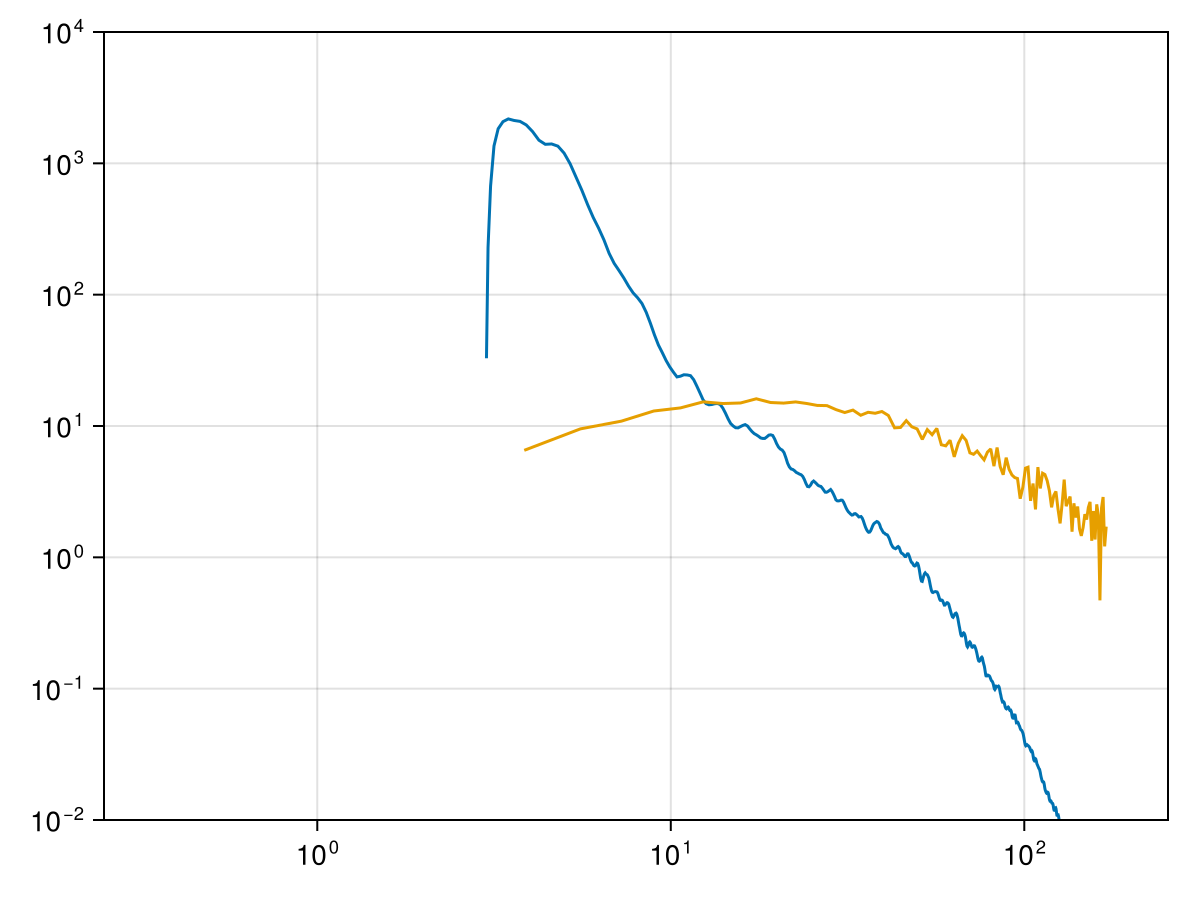

In [18]:
uw = irfft(uwh, grid.nx)
vw = irfft(vwh, grid.nx)
ηw = irfft(ηwh, grid.nx)

m1 = @. sqrt(1 + ηw) * uw
m2 = @. sqrt(1 + ηw) * vw
m1h = rfft(m1)
m2h = rfft(m2)

#scaling_factor = 
ρ, Ehr = FourierFlows.radialspectrum(abs2.(m1h) + abs2.(m2h), grid)
ωρ = @. sqrt(f0^2 + Cg^2*ρ^2)
fig = Figure()
ax = Axis(fig[1,1]; xscale=log10, yscale=log10, limits=((ρ[2], ρ[end]), (1e-2, 1e4)))
jacobian_factor = Cg^2*ρ./ωρ
lines!(ax, ωρ, grid.Lx^2 * Ehr[:] .* jacobian_factor / grid.nx^2)
lines!(ax, bin_centers, 40*energy_estimate)

fig

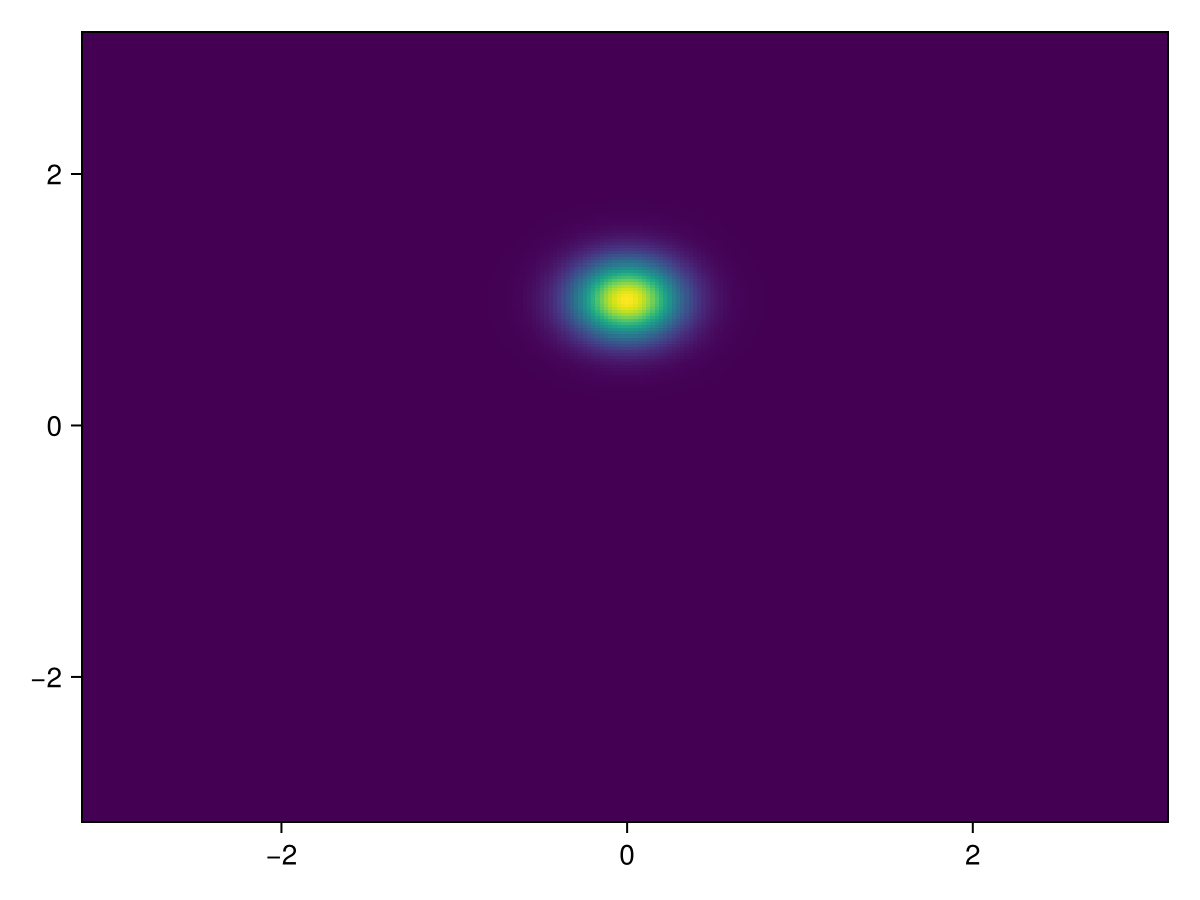

In [242]:
function envelope(x0, y0, env_size, grid)
    mod_x = @. mod(grid.x - x0 - grid.x[1], grid.Lx) + grid.x[1]
    mod_y = @. mod(grid.y' - y0 - grid.y[1], grid.Ly) + grid.y[1]
    return @. exp(-(mod_x/env_size)^2 - (mod_y/env_size)^2)
end

grid = TwoDGrid(;Lx=2π, nx=256)
heatmap(grid.x, grid.y, envelope(0, 1, 0.3, grid))

In [243]:
using LinearAlgebra: ldiv!, mul!
function envelope(x0, y0, env_size, grid)
    mod_x = @. mod(grid.x - x0 - grid.x[1], grid.Lx) + grid.x[1]
    mod_y = @. mod(grid.y' - y0 - grid.y[1], grid.Ly) + grid.y[1]
    return @. exp(-(mod_x/env_size)^2 - (mod_y/env_size)^2)
end

function create_single_wave_envelope(grid, x0, y0, k0_idx, l0_idx, phase, sign, env_size, aw, params)
    dev = typeof(grid.device)
    T = typeof(grid.Lx)
    
    @devzeros dev Complex{T} (grid.nkr, grid.nl) uwh vwh ηwh
    @devzeros dev T (grid.nx, grid.ny) uw vw ηw

    k0 = grid.kr[k0_idx]
    l0 = grid.l[l0_idx]
    Ksq = k0^2 + l0^2
    invKsq = 1/Ksq
    ωK = sqrt.(params.f^2 .+ params.Cg2 * Ksq)
    env = envelope(x0, y0, env_size, grid) 
    waveform = @. env * exp(1im * k0 * grid.x + 1im * l0 * grid.y' + 1im*phase)
    
    @. ηw = real(0.5 * waveform)
    @. uw = real(invKsq.*(0.5 * k0 .* ωK .+ 0.5im * rsw_params.f * l0) * waveform)
    @. vw = real(invKsq.*(0.5 * l0 .* ωK .- 0.5im * rsw_params.f * k0) * waveform)
    
    max_u = maximum(abs.(uw))
    @. ηw *= aw / max_u
    @. uw *= aw / max_u
    @. vw *= aw / max_u
    
    mul!(uwh, grid.rfftplan, uw)
    mul!(vwh, grid.rfftplan, vw)
    mul!(ηwh, grid.rfftplan, ηw)
    
    return uwh, vwh, ηwh
end

create_single_wave_envelope (generic function with 3 methods)

In [246]:
run_directory = "/scratch/nad9961/rsw_ray/66609698/1/"
Nsnapshots = count_snapshots(run_directory)
Nrsw_snapshots = count_key_snapshots(run_directory, "rsw")
rsw_params = read_rsw_params(run_directory)
nx, Lx = get_grid_size(run_directory, "rsw")
grid = TwoDGrid(; nx, Lx)

tf, xf, kf, uf = load_snapshot(run_directory, 5000)
t_rsw, sol1 = load_key_snapshot(run_directory, "rsw", Nrsw_snapshots)
Npackets = size(x0, 1)
u1h = sol1[:,:,1]
v1h = sol1[:,:,2]
η1h = sol1[:,:,3]
((ugh, vgh, ηgh), (uwh, vwh, ηwh)) = wave_balanced_decomposition(u1h, v1h, η1h, grid, rsw_params)
uwh, vwh, ηwh = create_single_wave_envelope(grid, π, 0, 100, 0, π/4, 1, 0.3, 0.1, rsw_params)

LoadError: BoundsError: attempt to access 1×512 Matrix{Float64} at index [0]

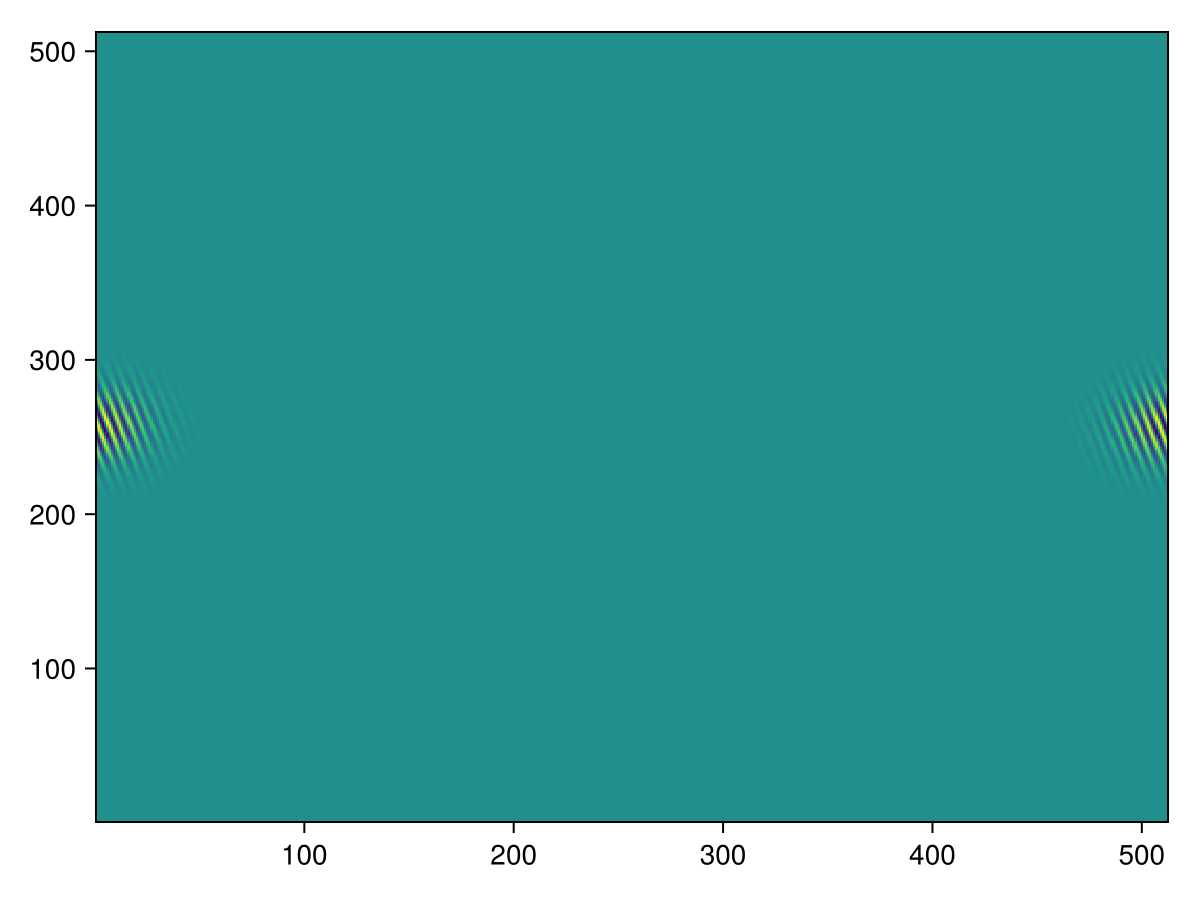

In [245]:
uw = irfft(uwh, grid.nx)
vw = irfft(vwh, grid.nx)
uwx = irfft(1im*grid.kr.*uwh, grid.nx)
vwy = irfft(1im*grid.l.*vwh, grid.nx)
ηw = irfft(ηwh, grid.nx)
heatmap(uwx + vwy, colorrange=(-10, 10))

In [209]:
maximum(abs.(uw))

0.1

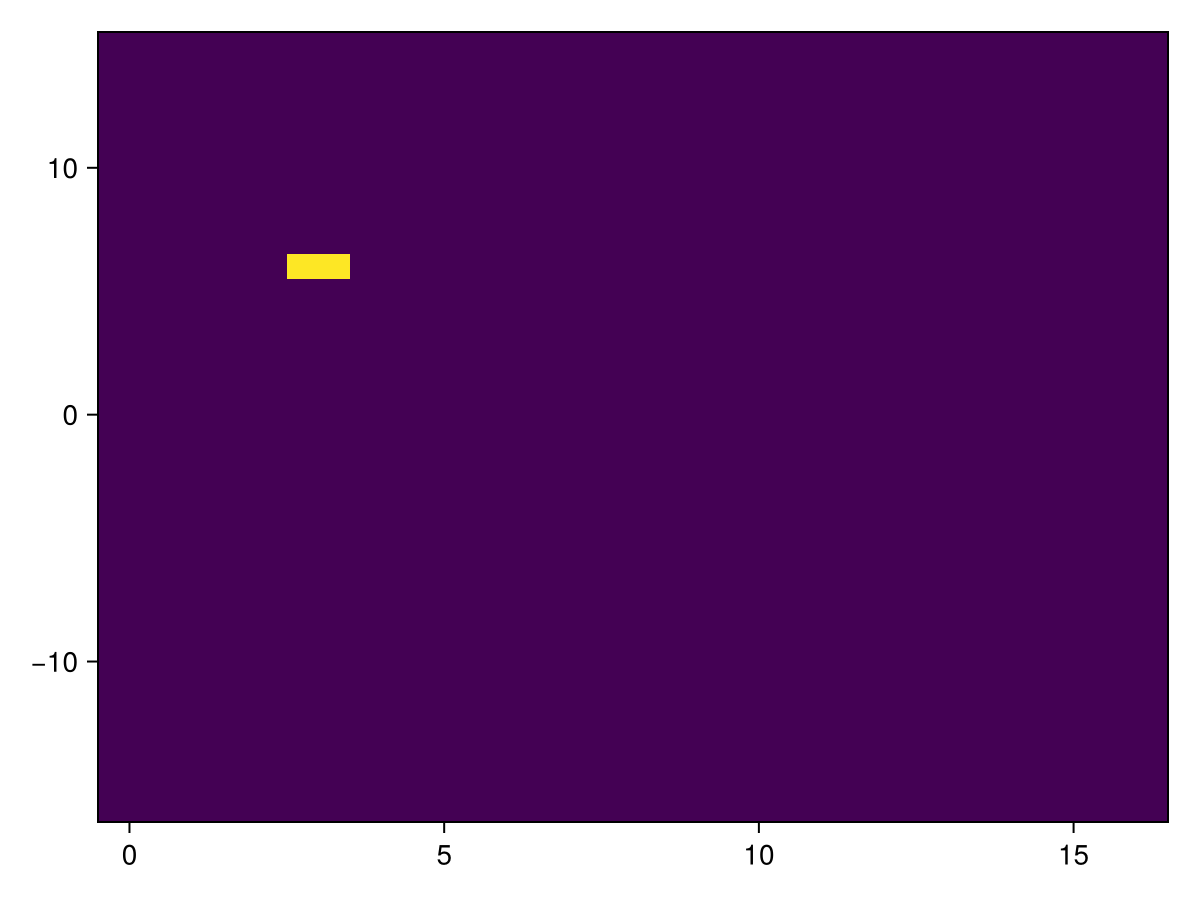

In [191]:
using AbstractFFTs

grid=TwoDGrid(; Lx=2π, nx=32)

dev = typeof(grid.device)
T = typeof(grid.Lx)

@devzeros dev Complex{T} (grid.nkr, grid.nl) uh vh ηh

k0_idx = 4
l0_idx = 7
k0 = grid.kr[k0_idx]
l0 = grid.l[l0_idx]
Ksq = k0^2 + l0^2
invKsq = 1/Ksq
ωK = sqrt.(rsw_params.f^2 .+ rsw_params.Cg2 * Ksq)
shift = exp(1im * 0*π/6)

ηh[k0_idx, l0_idx] = 0.5 * shift
uh[k0_idx, l0_idx] = invKsq.*(0.5 * k0 .* ωK .+ 0.5im * rsw_params.f * l0) * shift
vh[k0_idx, l0_idx] = invKsq.*(0.5 * l0 .* ωK .- 0.5im * rsw_params.f * k0) * shift

wave = @. exp(1im * k0 * grid.x + 1im * l0 * grid.y' + 1im*0*π/6)
η = @. 0.5 * wave
u = @. invKsq.*(0.5 * k0 .* ωK .+ 0.5im * rsw_params.f * l0) * wave
v = @. invKsq.*(0.5 * l0 .* ωK .- 0.5im * rsw_params.f * k0) * wave

η2h = rfft(real.(η))
u2h = rfft(real.(u))
v2h = rfft(real.(v))

heatmap(grid.kr[:], fftshift(grid.l[:]), fftshift(abs.(η2h), 2))

In [192]:
println((η2h[k0_idx, l0_idx]))
println((ηh[k0_idx, l0_idx]) * 512)

-256.0 + 3.0105871781791736e-14im
256.0 + 0.0im


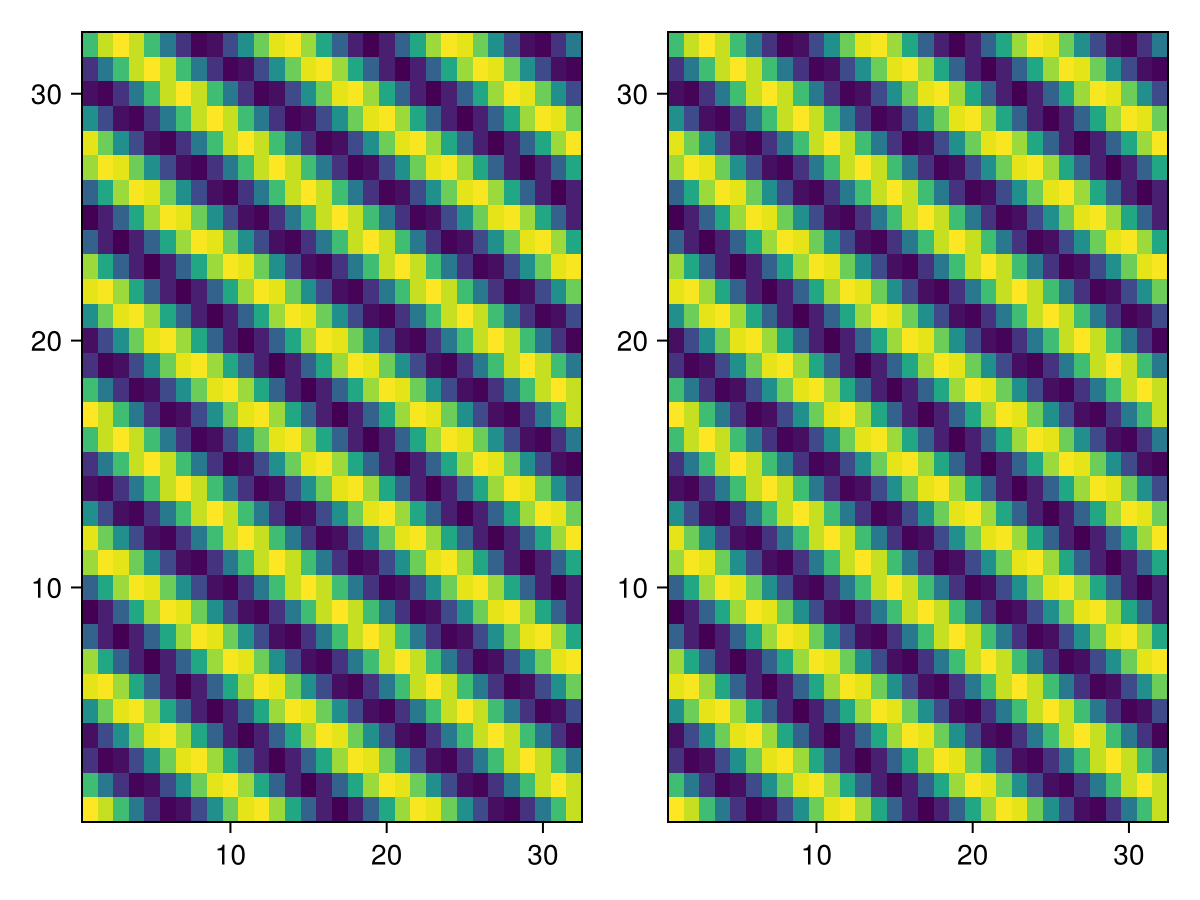

In [196]:
fig = Figure()
ax1 = Axis(fig[1,1])
ax2 = Axis(fig[1,2])

η = irfft(ηh, grid.nx)
η2 = irfft(η2h, grid.nx)
heatmap!(ax1, η)
heatmap!(ax2, -η2)

fig